In [1439]:
import sys
sys.path.append("/Users/gil/Documents/repos/c_pp_stuff/vp_trees_with_python_interface")
import vp_tree

import time

import numpy as np
from numpy import linalg as la
from numpy.random import normal
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs

from ipywidgets import interact
import pickle

In [1440]:
printing_calculations = False

In [1441]:
def make_gaussian_data(mu,sigma,num,dim):
    return (np.reshape(np.array([random.normalvariate(mu,sigma)
        for i in range(num*dim)]),(num,dim)) .tolist())

In [1695]:
def run_diffusion_map(data, params, symmetric = True):
    
    epsilon, gaussian_epsilon,alpha,data_size = params["epsilon"],params["gaussian_epsilon"],params["alpha"],params["data_size"]

    D = {tuple(value):i for i,value in enumerate(data)}

    t0 = time.time()
    tree = vp_tree.tree_container(data) ## make vp tree from data.
    t1 = time.time()
    s = tree.print_tree() ## string with tree contents.
    t2 = time.time()

    #### Diffusion Mapping.
    ## We use the default metric here.
    ## For the FS_metric, use: vp_tree.FS_metric(x,y).
    ## Remember to normalize x and y first!!
    ## print vp_tree.FS_metric((x/la.norm(x)).tolist(),(y/la.norm(y)).tolist())

    K = sparse.lil_matrix((data_size,data_size)) ## efficient format for constructing matrices.

    for i,x in enumerate(data):
        neighbors = tree.find_within_epsilon(x,epsilon)
        for y in neighbors:
            j = D[tuple(y)]
            K[i,j] = np.exp(-la.norm(np.asarray(x)-np.asarray(y))**2 / (2.0 * gaussian_epsilon))
    if printing_calculations: print "K = ", K.todense()

    if printing_calculations: print "total neighbors found = ", len(K.nonzero()[0])

    t3 = time.time()

    d_X = np.squeeze(np.asarray(K.sum(axis = 1)))
    if printing_calculations: print "d_X = ", d_X

    K_coo = sparse.coo_matrix(K) ## can iterate over (i,j,v) of coo_matrix
    L = sparse.lil_matrix((data_size,data_size))
    for i,j,v in zip(K_coo.row, K_coo.col, K_coo.data):
        L[i,j] = v * np.power(d_X[i] * d_X[j], -alpha)
    if printing_calculations: print "L = ",L.todense()

    D_no_power = np.squeeze(np.asarray(L.sum(axis = 1))) ## get diagonal elements of D
    
        ## non-symmetrized. Must use eigensolver that doesn't assume symmetry.

    ## symmetrized
    if symmetric:
        D_frac_pow = np.asarray([np.power(d, - 0.5) if not d == 0. else 0. for d in D_no_power])
        D_s = sparse.diags([D_frac_pow],[0],format = 'csr')
        if printing_calculations: print "D_s = ", D_s.todense()
        M = D_s * L.tocsr() * D_s
        if printing_calculations: print M.todense()
    else:
        D_frac_pow = np.asarray([np.power(d, - 1) if not d == 0. else 0. for d in D_no_power])
        D_s = sparse.diags([D_frac_pow],[0],format = 'csr')
        M = D_s * L.tocsr()

    t4 = time.time()

    if symmetric:
        e_vals,e_vecs = eigsh(M, k = params["eigen_dims"], maxiter = data_size * 100 )
    else:
        e_vals,e_vecs = eigs(M, k = params["eigen_dims"], maxiter = data_size * 100 )

    ## get real part, there should not be imaginary part.
    e_vals,e_vecs = e_vals.real,e_vecs.real
    l  = zip(e_vals,e_vecs.T)
    l.sort(key = lambda z: -z[0])
    e_vals,e_vecs = np.asarray([el[0] for el in l]),np.asarray([el[1] for el in l]).T
    
    t5 = time.time()

    if printing_calculations:
        print ("making the tree",t1-t0)
        print ("printing tree string (optional)",t2-t1)
        print ("Finding neighbors and generating K matrix", t3-t2)
        print ("calculations for M", t4-t3)
        print ("finding diffusion eigenvalues and eigenvectors",t5-t4)
        
    return e_vals,e_vecs

In [1650]:
params = {}

params["mus"] = [0.,-8.,8.] ## data distribution mean.
params["sigma"] = 1.0 ## data distribution standard deviation.
params["epsilon"] = 3. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 3. ## width of Gaussian kernel.
params["alpha"] = 0.5 ## coefficient to use for diffusion maps. See the wikipedia article.

params["dim"] = 1
params["data_size"] = 300
params["n"] = 3
params["eigen_dims"] = 4

In [1651]:
def generate_data_n_gaussians(params):
    if params["data_size"] % params["n"] != 0:
        print "data size must be divisible by " + str(params["n"]) + " ."
        return
    num_per_well = params["data_size"] / params["n"] ## assume it's even for now
    l = []
    for mu in params['mus']:
        l += make_gaussian_data(mu,params["sigma"],num_per_well,params["dim"])
    return l

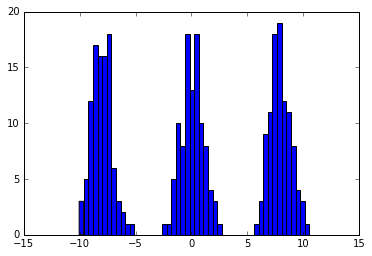

In [1652]:
## Make three well-separated Gaussians

data = generate_data_n_gaussians(params)
data.sort(key = lambda z: z[0] / abs(z[0]) * np.sqrt(sum([el**2 for el in z])))
plt.hist([el[0] for el in np.asarray(data)],bins=50);

[ 1.          1.          1.          0.31037668]


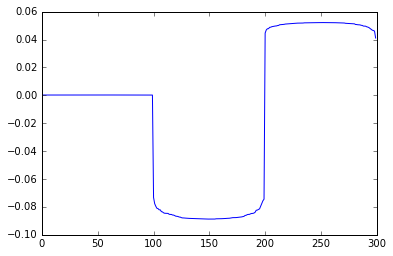

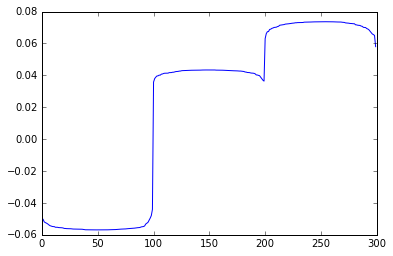

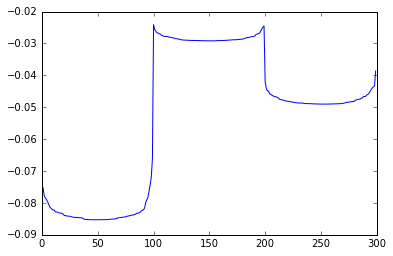

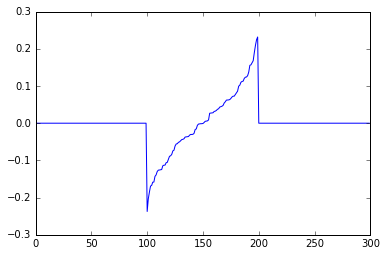

In [1653]:
## alpha == 0.5 case. This corresponds to a diffusion.

params["alpha"] = 0.5 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)

e_vals / la.norm(e_vals)
print e_vals
for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

[ 1.          1.          1.          0.34578544]


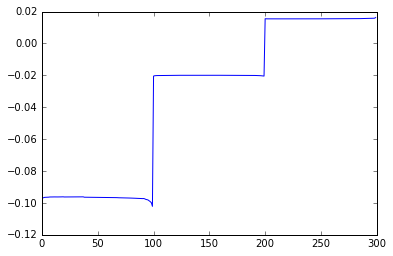

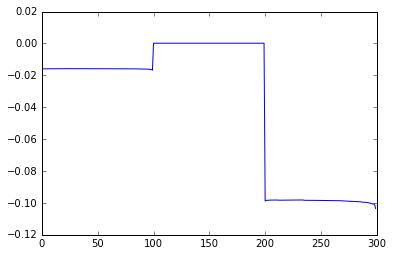

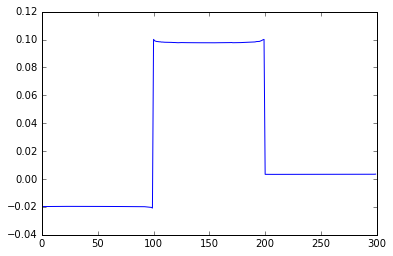

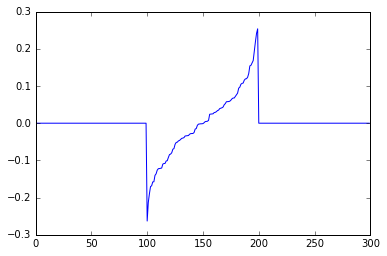

In [1654]:
## alpha == 1 case finds coordinates regardless of probability density.

params["alpha"] = 1.0 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)
e_vals / la.norm(e_vals)
print e_vals
for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

Something fun to try for the $\alpha = 1$ case at least:

[ 1.          1.          1.          0.27977377]


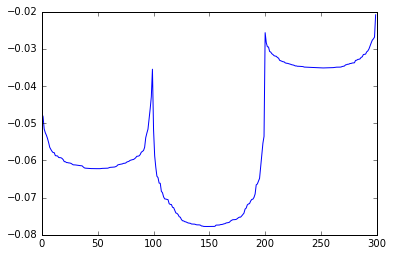

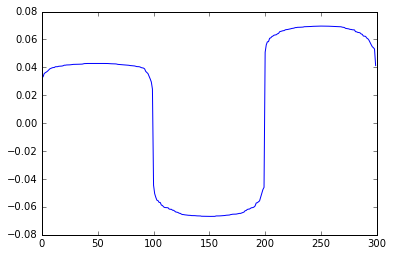

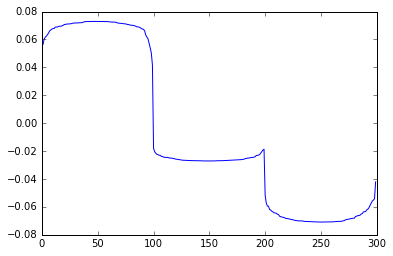

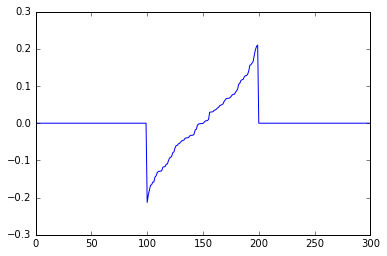

In [1655]:
## Finally, alpha == 0 is the 

params["alpha"] = 0.0 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)
e_vals / la.norm(e_vals)
print e_vals

for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

## 1D experiment

Let's replicate example 1 in http://pca.narod.ru/10MainGorbanKeglWunschZin.pdf

Furthermore, let's see what happens as we change the radius $epsilon$ to see how the results depend on the radius of the Gaussian chosen.

The average distance between points is 0.0833. Below we experiment with different values of the Gaussian radius. 

In [1675]:
from mpl_toolkits.mplot3d import Axes3D

In [1676]:
t = sorted([random.uniform(0, 15*np.pi/2) for i in range(400)])

In [1677]:
xs,ys,zs = list(np.cos(t)), list(t), list(np.sin(t))

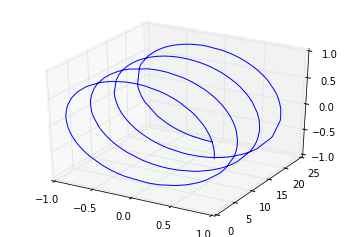

In [1678]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs)

In [1679]:
data = [[x,y,z] for x,y,z in zip(xs,ys,zs)]

In [ ]:
params = {}
params["epsilon"] = 100. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 20. ## width of Gaussian kernel.
params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

params["data_size"] = 400
params["eigen_dims"] = 3

e_vals, e_vecs = run_diffusion_map(data, params)
v1,v2 = (e_vecs.T)[0:2]
plt.scatter(v1,v2)

In [1694]:
def make_vecs(gauss_eps):
    params = {}
    params["epsilon"] = 15. ## cutoff for nearest neighbors.
    params["gaussian_epsilon"] = gauss_eps ## width of Gaussian kernel.
    params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

    params["data_size"] = 400
    params["eigen_dims"] = 3

    e_vals, e_vecs = run_diffusion_map(data, params)
    v1,v2 = (e_vecs.T)[:2]
    return v1,v2

In [1657]:
stepping_tuple = low,high,inter = 0,48,1
D = {i:val for i,val in enumerate(np.linspace(0.1,5.0,50))}

In [1644]:
plot_scatter = {}
for i in range(high):
    plot_scatter[i] = make_vecs(D[i])

In [1645]:
def plot_scatter_saved(i):
    v1,v2 = plot_scatter[i]
    plt.figure(figsize=(10,10))    
    plt.scatter(v1,v2)
    plt.show()

In [1646]:
F = lambda i: plot_scatter_saved(i)

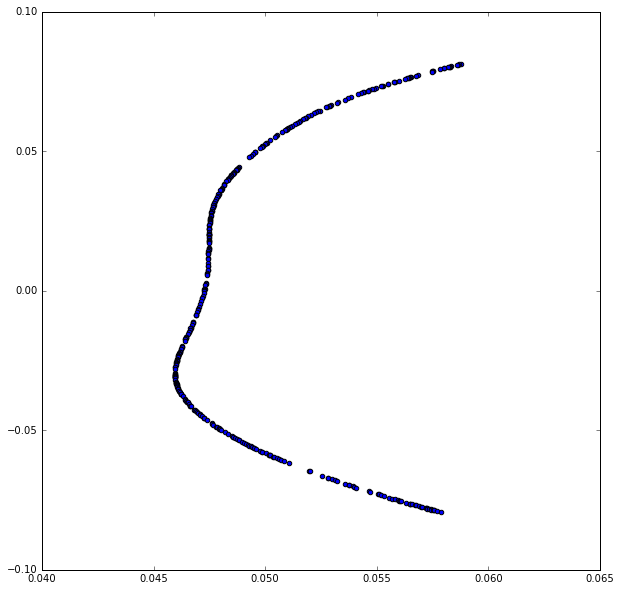

In [1658]:
interact(F, i=stepping_tuple )

In [1648]:
## write to file
pickle.dump( plot_scatter, open( "scatterplots.p", "wb" ) )

In [1429]:
## read from file
plot_scatter = pickle.load( open( "scatterplots.p", "rb" ) )